### loading necessary imports

### loading the data

In [43]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

def load_split_save_data(processed_data_path: Path, artifacts_path: Path, test_size=0.3, random_state=40):
    """Load processed data, split into train/test, and save to artifacts."""
    
    # Load data
    df = pd.read_parquet(processed_data_path)
    
    # Check target
    if 'target' not in df.columns:
        raise ValueError("Target column 'target' not found")
    
    # Split
    X = df.drop('target', axis=1)
    y = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Save
    artifacts_path.mkdir(parents=True, exist_ok=True)
    X_train.to_parquet(artifacts_path / 'X_train.parquet', index=False)
    X_test.to_parquet(artifacts_path / 'X_test.parquet', index=False)
    y_train.to_frame().to_parquet(artifacts_path / 'y_train.parquet', index=False)
    y_test.to_frame().to_parquet(artifacts_path / 'y_test.parquet', index=False)
    
    return X_train, X_test, y_train, y_test

def load_split_data(artifacts_path: Path):
    """Load already split data from artifacts."""
    
    X_train = pd.read_parquet(artifacts_path / 'X_train.parquet')
    X_test = pd.read_parquet(artifacts_path / 'X_test.parquet')
    y_train = pd.read_parquet(artifacts_path / 'y_train.parquet').iloc[:, 0]
    y_test = pd.read_parquet(artifacts_path / 'y_test.parquet').iloc[:, 0]
    
    return X_train, X_test, y_train, y_test

if __name__ == '__main__':
    # Find project root
    PROJECT_ROOT = Path.cwd()
    while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
        PROJECT_ROOT = PROJECT_ROOT.parent
    
    # Paths
    PROCESSED_DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'processed_data.parquet'
    ARTIFACTS_PATH = PROJECT_ROOT / 'artifacts' / 'split data sets'
    
    print(f"✓ Project root: {PROJECT_ROOT}")
    print(f"✓ Processed data: {PROCESSED_DATA_PATH}")
    print(f"✓ Artifacts: {ARTIFACTS_PATH}\n")
    
    # Check file exists
    if not PROCESSED_DATA_PATH.exists():
        print(f"❌ ERROR: Processed data not found at: {PROCESSED_DATA_PATH}")
        exit(1)
    
    # Load, split and save
    X_train, X_test, y_train, y_test = load_split_save_data(
        processed_data_path=PROCESSED_DATA_PATH,
        artifacts_path=ARTIFACTS_PATH
    )
    
    # Summary
    print("="*60)
    print("✓ DATA PREPARATION COMPLETE")
    print("="*60)
    print(f"Train: {X_train.shape} | Test: {X_test.shape}")
    print(f"Train target: {y_train.value_counts().to_dict()}")
    print(f"Test target: {y_test.value_counts().to_dict()}")
    print(f"Saved to: {ARTIFACTS_PATH}")
    print("="*60)

✓ Project root: p:\projects\heart_disease_prediction
✓ Processed data: p:\projects\heart_disease_prediction\data\processed\processed_data.parquet
✓ Artifacts: p:\projects\heart_disease_prediction\artifacts\split data sets

✓ DATA PREPARATION COMPLETE
Train: (48979, 14) | Test: (20992, 14)
Train target: {0: 24500, 1: 24479}
Test target: {0: 10501, 1: 10491}
Saved to: p:\projects\heart_disease_prediction\artifacts\split data sets


### Preprocessing of data

In [2]:
# ============================================================================
# 0. Import Packages
# ============================================================================
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

# ============================================================================
# 1. PATH SETUP
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts' / 'split data sets'
PROCESSED_FILE = PROCESSED_DIR / 'processed_data.parquet'

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print(f" Paths configured:")
print(f" Processed: {PROCESSED_DIR}")
print(f" Artifacts: {ARTIFACTS_DIR}")

# ============================================================================
# 2. LOAD EXISTING PROCESSED DATA
# ============================================================================
if not PROCESSED_FILE.exists():
    print(f" ERROR: File not found: {PROCESSED_FILE}")
    raise FileNotFoundError(f"Processed data file missing: {PROCESSED_FILE}")

df = pd.read_parquet(PROCESSED_FILE)
print(f"\n Loaded processed data: {df.shape}")

# ============================================================================
# 3. FEATURE SELECTION
# ============================================================================
# Use all columns except for the target as features.
feature_cols = [col for col in df.columns if col != 'target']

# Prepare for modeling (NO additional preprocessing needed)
X = df[feature_cols]
y = df['target']

print(f"\n Data characteristics:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features: {feature_cols}")
print(f"   Data is ready for train/test split")

# ============================================================================
# 4. TRAIN/TEST SPLIT (Always overwrites artifacts)
# ============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Save split data (overwrites existing files)
X_train.to_parquet(ARTIFACTS_DIR / 'X_train.parquet', index=False)
X_test.to_parquet(ARTIFACTS_DIR / 'X_test.parquet', index=False)
y_train.to_frame().to_parquet(ARTIFACTS_DIR / 'y_train.parquet', index=False)
y_test.to_frame().to_parquet(ARTIFACTS_DIR / 'y_test.parquet', index=False)

print(f"\nSaved split data to: {ARTIFACTS_DIR}")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  Train target distribution: {y_train.value_counts().to_dict()}")
print(f"  Test target distribution: {y_test.value_counts().to_dict()}")

# ============================================================================
# 5. VERIFY DATA IS READY
# ============================================================================
print(f"Features ({len(X_train.columns)}):")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i:2d}. {col}")

 Paths configured:
 Processed: p:\projects\heart_disease_prediction\data\processed
 Artifacts: p:\projects\heart_disease_prediction\artifacts\split data sets

 Loaded processed data: (69971, 15)

 Data characteristics:
   Total features: 14
   Features: ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 'Age_Group', 'BP_Group', 'PP_Group', 'MAP_Group', 'BMI_Group', 'Age_SystolicBP', 'BMI_MetabolicVascularLoad', 'Age_HemodynamicLoad_Chol']
   Data is ready for train/test split

Saved split data to: p:\projects\heart_disease_prediction\artifacts\split data sets
  X_train: (48979, 14)
  X_test: (20992, 14)
  Train target distribution: {0: 24500, 1: 24479}
  Test target distribution: {0: 10501, 1: 10491}
Features (14):
   1. Sex
   2. Cholesterol_Level
   3. Glucose_Level
   4. Smoking_Status
   5. Alcohol_Intake
   6. Physical_Activity
   7. Age_Group
   8. BP_Group
   9. PP_Group
  10. MAP_Group
  11. BMI_Group
  12. Age_SystolicBP
  13

### Base model selection

In [49]:
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# ============================================================================
# LOAD DATA
# ============================================================================
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts' / 'split data sets'

X_train = pd.read_parquet(ARTIFACTS_DIR / 'X_train.parquet')
X_test = pd.read_parquet(ARTIFACTS_DIR / 'X_test.parquet')
y_train = pd.read_parquet(ARTIFACTS_DIR / 'y_train.parquet').iloc[:, 0]
y_test = pd.read_parquet(ARTIFACTS_DIR / 'y_test.parquet').iloc[:, 0]

print(f"✓ Data loaded: Train {X_train.shape}, Test {X_test.shape}\n")

# ============================================================================
# MODELS
# ============================================================================
models = {
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        tree_method='gpu_hist', gpu_id=0,
        random_state=42, verbosity=0
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        num_leaves=15, subsample=0.8, colsample_bytree=0.8,
        random_state=42, verbose=-1, n_jobs=-1
    ),
    
    'CatBoost': CatBoostClassifier(
        iterations=200, depth=4, learning_rate=0.05,
        l2_leaf_reg=3, random_strength=1,
        bagging_temperature=1, border_count=128,
        random_seed=42, verbose=False
    ),
    
    'RandomForest': RandomForestClassifier(
        n_estimators=200, max_depth=6, min_samples_split=20,
        max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=200, max_depth=8, min_samples_split=15,
        max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, max_features='sqrt', random_state=42
    ),
    
    'LogisticRegression': LogisticRegression(
        C=1.0, penalty='l2', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    
    'GaussianNB': GaussianNB()
}

# ============================================================================
# EVALUATE
# ============================================================================
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)
    
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    return {
        'Model': '',
        'Test_AUC': test_auc,
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test, y_test_pred, zero_division=0),
        'F1': f1_score(y_test, y_test_pred, zero_division=0),
        'Train_AUC': train_auc,
        'CV_AUC_Mean': cv_scores.mean(),
        'CV_AUC_Std': cv_scores.std(),
        'Overfitting_Gap': train_auc - test_auc
    }

# ============================================================================
# RUN EVALUATION
# ============================================================================
print("Evaluating models...\n")

results = []
for name, model in models.items():
    try:
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        metrics['Model'] = name
        results.append(metrics)
        print(f"✓ {name}")
    except Exception as e:
        print(f"✗ {name}: {str(e)[:50]}")

# ============================================================================
# RESULTS
# ============================================================================
print("\n" + "="*110)
df_baseline_metrics = pd.DataFrame(results)
df_baseline_metrics = df_baseline_metrics.sort_values('Test_AUC', ascending=False).reset_index(drop=True)
print(df_baseline_metrics.to_string(index=False))

✓ Data loaded: Train (48979, 14), Test (20992, 14)

Evaluating models...

✓ XGBoost
✓ LightGBM
✓ CatBoost
✓ RandomForest
✓ ExtraTrees
✓ GradientBoosting
✓ LogisticRegression
✓ GaussianNB

             Model  Test_AUC  Accuracy  Precision  Recall     F1  Train_AUC  CV_AUC_Mean  CV_AUC_Std  Overfitting_Gap
           XGBoost    0.7991    0.7338     0.7525  0.6963 0.7233     0.8113       0.8021      0.0034           0.0122
  GradientBoosting    0.7988    0.7321     0.7498  0.6963 0.7221     0.8105       0.8020      0.0032           0.0116
          LightGBM    0.7985    0.7329     0.7520  0.6947 0.7222     0.8111       0.8018      0.0033           0.0126
          CatBoost    0.7981    0.7314     0.7529  0.6884 0.7192     0.8047       0.8016      0.0035           0.0066
        ExtraTrees    0.7957    0.7297     0.7677  0.6583 0.7088     0.8042       0.7987      0.0027           0.0084
      RandomForest    0.7956    0.7306     0.7505  0.6904 0.7192     0.8039       0.7992      0.0031    

### Model Selection and Calibration

In [26]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import joblib
import json
import gc
from tqdm import tqdm

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.ERROR)

# ============================================================================
# CONFIG
# ============================================================================
RANDOM_STATE = 42
TRAIN_SIZE = 0.70
VAL_SIZE = 0.10
CAL_SIZE = 0.10
TEST_SIZE = 0.10
TRIALS = {'xgb': 80, 'lgbm': 80, 'cat': 80}
N_ESTIMATORS = 2000
CAT_ITERATIONS = 300

np.random.seed(RANDOM_STATE)
import random
random.seed(RANDOM_STATE)

# ============================================================================
# THRESHOLD OPTIMIZATION
# ============================================================================
def optimize_threshold_max_f1(y_true, y_proba):
    results = []
    thresholds = np.arange(0.10, 0.95, 0.005)
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = f1_score(y_true, y_pred) if (tp + fp) > 0 or (tp + fn) > 0 else 0
        
        results.append({
            'threshold': threshold, 'sensitivity': sens, 'specificity': spec,
            'balanced_acc': (sens + spec) / 2, 'f1': f1, 'youden_j': sens + spec - 1,
            'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
        })
    
    df = pd.DataFrame(results)
    return df.loc[df['f1'].idxmax()].to_dict(), df

# ============================================================================
# MODEL OPTIMIZATION
# ============================================================================
def optimize_model(model_type, X_tr, y_tr, X_v, y_v):
    pbar = tqdm(total=TRIALS[model_type], desc=f"  {model_type.upper()}")
    
    def objective(trial):
        try:
            if model_type == 'xgb':
                params = {
                    'n_estimators': N_ESTIMATORS, 'max_depth': trial.suggest_int('max_depth', 3, 6),
                    'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.12, log=True),
                    'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
                    'gamma': trial.suggest_float('gamma', 0.1, 2.0),
                    'subsample': trial.suggest_float('subsample', 0.65, 0.9),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.65, 0.9),
                    'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 4.0),
                    'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 4.0),
                    'tree_method': 'gpu_hist', 'gpu_id': 0, 'random_state': RANDOM_STATE, 'verbosity': 0
                }
                model = XGBClassifier(**params)
                model.fit(X_tr, y_tr, eval_set=[(X_v, y_v)], early_stopping_rounds=50, verbose=False)
                
            elif model_type == 'lgbm':
                params = {
                    'n_estimators': N_ESTIMATORS, 'max_depth': trial.suggest_int('max_depth', 3, 7),
                    'num_leaves': trial.suggest_int('num_leaves', 15, 50),
                    'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.12, log=True),
                    'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
                    'subsample': trial.suggest_float('subsample', 0.65, 0.9),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.65, 0.9),
                    'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 4.0),
                    'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 4.0),
                    'random_state': RANDOM_STATE, 'verbosity': -1, 'device': 'cpu'
                }
                model = LGBMClassifier(**params)
                model.fit(X_tr, y_tr, eval_set=[(X_v, y_v)], callbacks=[lgb.early_stopping(50, verbose=False)])
                
            else:
                params = {
                    'iterations': CAT_ITERATIONS,
                    'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15, log=True),
                    'depth': trial.suggest_int('depth', 5, 7),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.0),
                    'random_strength': trial.suggest_float('random_strength', 0.5, 1.5),
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 25),
                    'bootstrap_type': 'Bayesian',
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.2),
                    'task_type': 'GPU', 'random_seed': RANDOM_STATE, 'verbose': False
                }
                model = CatBoostClassifier(**params)
                model.fit(Pool(X_tr, y_tr), eval_set=Pool(X_v, y_v), early_stopping_rounds=30, verbose=False)

            y_pred_proba = model.predict_proba(X_v)[:, 1]
            best_f1 = 0
            for threshold in np.arange(0.1, 0.9, 0.05):
                y_pred_temp = (y_pred_proba >= threshold).astype(int)
                f1_temp = f1_score(y_v, y_pred_temp)
                if f1_temp > best_f1:
                    best_f1 = f1_temp
            
            pbar.update(1)
            gc.collect()
            return best_f1
        except:
            pbar.update(1)
            return 0.0
    
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=TRIALS[model_type], n_jobs=1, show_progress_bar=False)
    pbar.close()
    return study.best_params

# ============================================================================
# MAIN PIPELINE
# ============================================================================
print("\n[1/6] Loading data...")
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

data_dir = PROJECT_ROOT / 'artifacts' / 'split data sets'
MODEL_DIR = PROJECT_ROOT / 'artifacts' / 'model'

if not MODEL_DIR.exists():
    MODEL_DIR.mkdir(parents=True)

# Load full dataset
X_train = pd.read_parquet(data_dir / 'X_train.parquet')
X_test = pd.read_parquet(data_dir / 'X_test.parquet')
y_train = pd.read_parquet(data_dir / 'y_train.parquet').iloc[:, 0]
y_test = pd.read_parquet(data_dir / 'y_test.parquet').iloc[:, 0]

# Combine train and test for full dataset
X_full = pd.concat([X_train, X_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)

# Split 1: 70% train, 30% temp
X_train_final, X_temp, y_train_final, y_temp = train_test_split(
    X_full, y_full, test_size=0.30, stratify=y_full, random_state=RANDOM_STATE
)

# Split 2: temp into 10% val (1/3 of 30%), 20% temp2 (2/3 of 30%)
X_val, X_temp2, y_val, y_temp2 = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=RANDOM_STATE
)

# Split 3: temp2 into 10% cal, 10% test (50/50 split of 20%)
X_cal, X_test_final, y_cal, y_test_final = train_test_split(
    X_temp2, y_temp2, test_size=0.5, stratify=y_temp2, random_state=RANDOM_STATE
)

print(f"  Total:       {len(X_full):,} samples")
print(f"  Train:       {len(X_train_final):,} ({len(X_train_final)/len(X_full)*100:.0f}%)")
print(f"  Validation:  {len(X_val):,} ({len(X_val)/len(X_full)*100:.0f}%)")
print(f"  Calibration: {len(X_cal):,} ({len(X_cal)/len(X_full)*100:.0f}%)")
print(f"  Test:        {len(X_test_final):,} ({len(X_test_final)/len(X_full)*100:.0f}%)")

del X_full, y_full, X_temp, y_temp, X_temp2, y_temp2, X_train, X_test, y_train, y_test
gc.collect()

# ============================================================================
print("\n[2/6] Hyperparameter optimization...")
xgb_params = optimize_model('xgb', X_train_final, y_train_final, X_val, y_val)
gc.collect()
lgbm_params = optimize_model('lgbm', X_train_final, y_train_final, X_val, y_val)
gc.collect()
cat_params = optimize_model('cat', X_train_final, y_train_final, X_val, y_val)
gc.collect()

# ============================================================================
print("\n[3/6] Training base models...")
models = {}

# Combine train and validation for final training
X_train_full = pd.concat([X_train_final, X_val], ignore_index=True)
y_train_full = pd.concat([y_train_final, y_val], ignore_index=True)

try:
    xgb_params.update({'n_estimators': N_ESTIMATORS, 'tree_method': 'gpu_hist', 
                       'random_state': RANDOM_STATE, 'verbosity': 0, 'gpu_id': 0})
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train_full, y_train_full, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    models['XGBoost'] = {'model': xgb_model, 'params': xgb_params}
    gc.collect()
except:
    pass

try:
    lgbm_params.update({'n_estimators': N_ESTIMATORS, 'random_state': RANDOM_STATE, 'verbosity': -1})
    lgbm_model = LGBMClassifier(**lgbm_params)
    lgbm_model.fit(X_train_full, y_train_full, eval_set=[(X_val, y_val)],
                   callbacks=[lgb.early_stopping(50, verbose=False)])
    models['LightGBM'] = {'model': lgbm_model, 'params': lgbm_params}
    gc.collect()
except:
    pass

try:
    cat_params.update({'iterations': CAT_ITERATIONS, 'task_type': 'GPU', 
                       'random_seed': RANDOM_STATE, 'verbose': False})
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(Pool(X_train_full, y_train_full), eval_set=Pool(X_val, y_val),
                  early_stopping_rounds=30, verbose=False)
    models['CatBoost'] = {'model': cat_model, 'params': cat_params}
    gc.collect()
except:
    pass

# ============================================================================
print("\n[4/6] Calibrating models...")
calibrated_models = {}

for model_name, model_info in models.items():
    calibrated = CalibratedClassifierCV(model_info['model'], method='isotonic', cv='prefit')
    calibrated.fit(X_cal, y_cal)
    cal_proba = calibrated.predict_proba(X_test_final)[:, 1]
    
    calibrated_models[model_name] = {
        'calibrated_model': calibrated,
        'base_model': model_info['model'],
        'params': model_info['params'],
        'cal_proba': cal_proba,
        'cal_auc': roc_auc_score(y_test_final, cal_proba)
    }
    gc.collect()

# ============================================================================
print("\n[5/6] Optimizing thresholds...")

for model_name, model_info in calibrated_models.items():
    best_threshold, _ = optimize_threshold_max_f1(y_test_final, model_info['cal_proba'])
    calibrated_models[model_name]['optimal_threshold'] = best_threshold

# ============================================================================
best_name = max(calibrated_models, key=lambda k: calibrated_models[k]['optimal_threshold']['f1'])
best_info = calibrated_models[best_name]
best_opt = best_info['optimal_threshold']

print("\n" + "="*80)
print(f"BEST MODEL: {best_name}")
print("="*80)
print(f"  Threshold:   {best_opt['threshold']:.4f}")
print(f"  F1 Score:    {best_opt['f1']:.4f}")
print(f"  Sensitivity: {best_opt['sensitivity']:.3f}")
print(f"  Specificity: {best_opt['specificity']:.3f}")
print(f"  AUC:         {best_info['cal_auc']:.4f}")
print("="*80)

# ============================================================================
print("\n[6/6] Saving model...")

features = X_train_final.columns.tolist()

joblib.dump({
    'model': best_info['base_model'],
    'model_type': best_name,
    'features': features,
    'hyperparameters': best_info['params']
}, MODEL_DIR / 'best_model_base.pkl', compress=3)

joblib.dump({
    'calibrated_model': best_info['calibrated_model'],
    'base_model': best_info['base_model'],
    'model_type': best_name,
    'features': features,
    'optimal_threshold': float(best_opt['threshold']),
    'threshold_strategy': 'max_f1',
    'performance': {
        'auc': float(best_info['cal_auc']),
        'f1_score': float(best_opt['f1']),
        'sensitivity': float(best_opt['sensitivity']),
        'specificity': float(best_opt['specificity']),
        'balanced_accuracy': float(best_opt['balanced_acc']),
        'confusion_matrix': {
            'tn': int(best_opt['tn']), 'fp': int(best_opt['fp']),
            'fn': int(best_opt['fn']), 'tp': int(best_opt['tp'])
        }
    }
}, MODEL_DIR / 'best_model_calibrated.pkl', compress=3)

metadata = {
    'random_state': RANDOM_STATE,
    'best_model': best_name,
    'optimal_threshold': float(best_opt['threshold']),
    'performance': {
        'auc': float(best_info['cal_auc']),
        'f1_score': float(best_opt['f1']),
        'sensitivity': float(best_opt['sensitivity']),
        'specificity': float(best_opt['specificity']),
        'balanced_accuracy': float(best_opt['balanced_acc'])
    },
    'features': features,
    'data_splits': {
        'total_samples': len(X_train_final) + len(X_val) + len(X_cal) + len(X_test_final),
        'train': len(X_train_final),
        'validation': len(X_val),
        'calibration': len(X_cal),
        'test': len(X_test_final),
        'split_ratio': '70/10/10/10'
    }
}

with open(MODEL_DIR / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

gc.collect()
print("\nCompleted!\n")


[1/6] Loading data...
  Total:       69,971 samples
  Train:       48,979 (70%)
  Validation:  6,997 (10%)
  Calibration: 6,997 (10%)
  Test:        6,998 (10%)

[2/6] Hyperparameter optimization...


  CAT: 100%|██████████| 80/80 [01:47<00:00,  1.35s/it]



[3/6] Training base models...

[4/6] Calibrating models...

[5/6] Optimizing thresholds...

BEST MODEL: CatBoost
  Threshold:   0.3150
  F1 Score:    0.7473
  Sensitivity: 0.854
  Specificity: 0.568
  AUC:         0.8060

[6/6] Saving model...

Completed!



### Evaluation Metrics Summary

⚡ Best Calibrated Model Evaluation

Loading: best_model_calibrated.pkl
✓ Model Type: CatBoost
✓ Optimal Threshold: 0.3150
✓ Threshold Strategy: max_f1
✓ Features: 14
✓ Saved Performance Metrics:
    auc: 0.8060
    f1_score: 0.7473
    sensitivity: 0.8544
    specificity: 0.5681
    balanced_accuracy: 0.7113

Loading test data...
✓ Test set size: (20992, 14)

Generating predictions...
✓ Predictions generated

Computing metrics...
✓ Metrics computed

Generating visualizations...

✓ Saved: 01_performance_dashboard.png


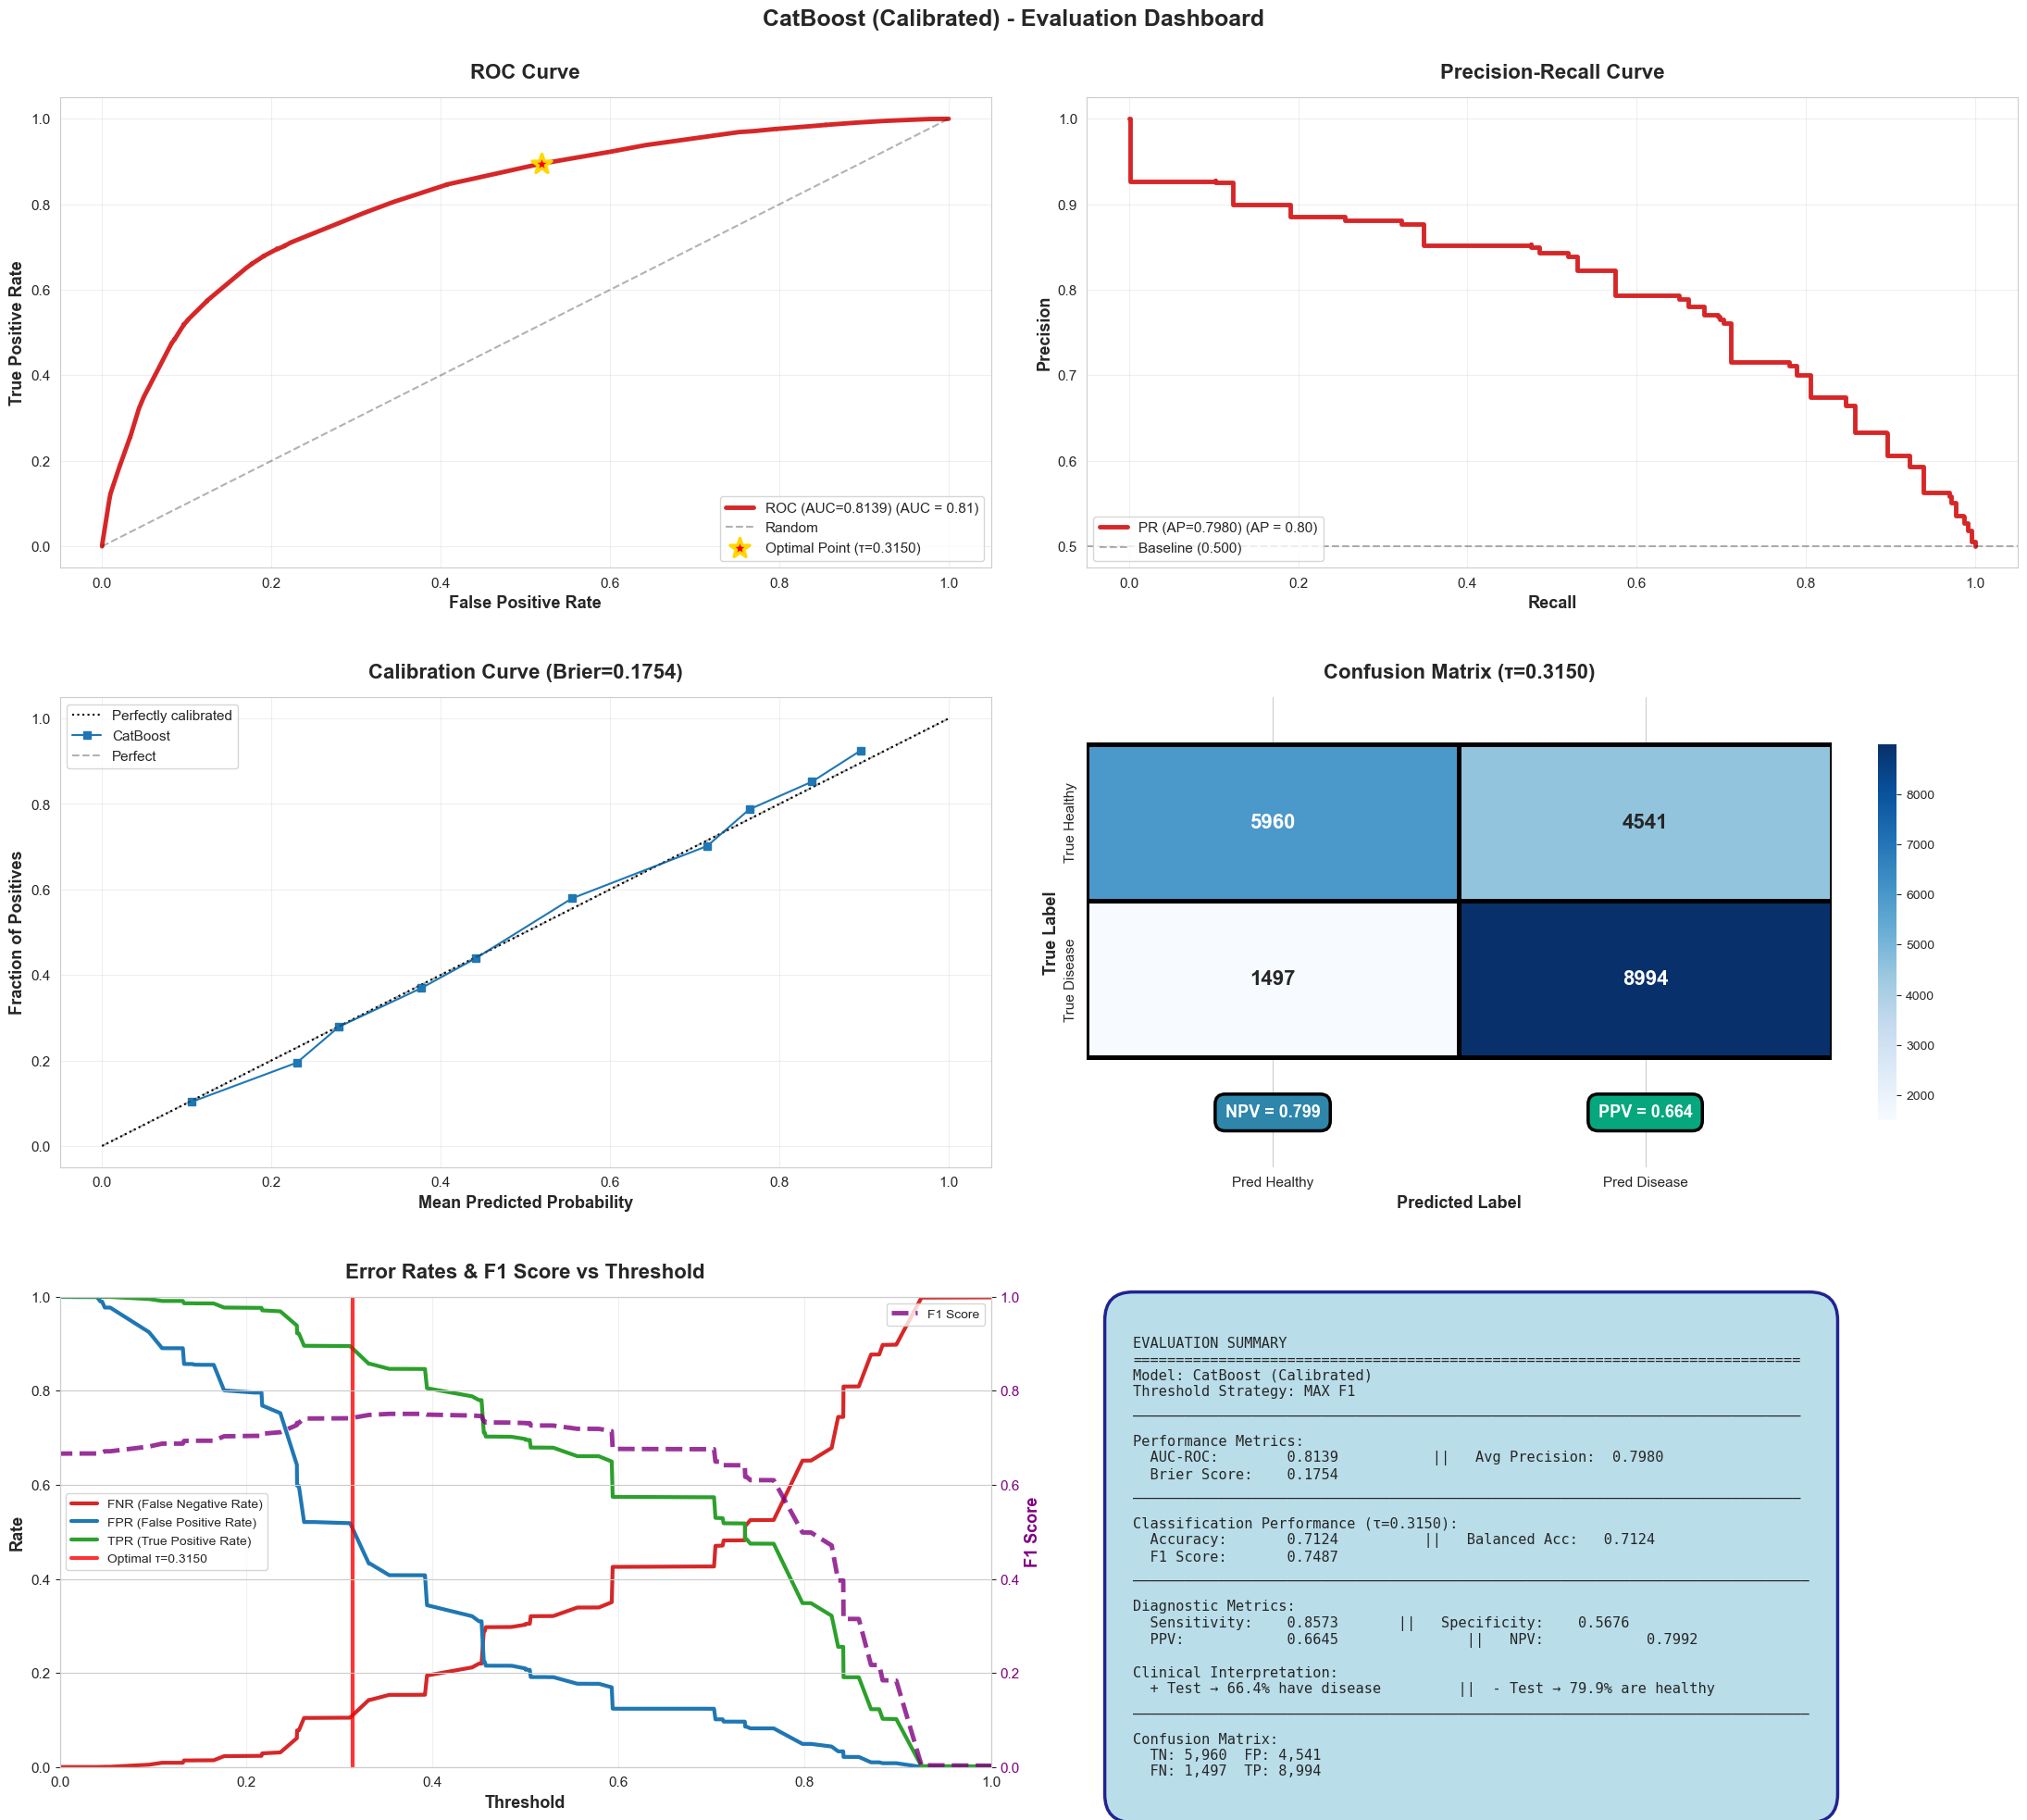


Saving evaluation metrics...
✓ Saved: evaluation_metrics.json

EVALUATION COMPLETED SUCCESSFULLY


In [27]:
# ============================================================================
# EVALUATION CODE - BEST CALIBRATED MODEL
# ============================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import (
    roc_auc_score, f1_score, roc_curve, precision_recall_curve,
    confusion_matrix, average_precision_score, brier_score_loss,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import CalibrationDisplay

import matplotlib.pyplot as plt
import seaborn as sns

print("⚡ Best Calibrated Model Evaluation\n")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
data_dir = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling'
FIGURES_DIR = REPORTS_DIR / 'baseline model' / 'figures'
metrics_dir = REPORTS_DIR / 'baseline model' / 'metrics'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
metrics_dir.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD MODEL
# ============================================================================

model_path = MODEL_DIR / 'best_model_calibrated.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

print(f"Loading: {model_path.name}")
artifacts = joblib.load(model_path)

# Extract model and metadata
model = artifacts['calibrated_model']
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')
optimal_threshold = artifacts.get('optimal_threshold', 0.5)
threshold_strategy = artifacts.get('threshold_strategy', 'unknown')
performance = artifacts.get('performance', {})

print(f"✓ Model Type: {model_type}")
print(f"✓ Optimal Threshold: {optimal_threshold:.4f}")
print(f"✓ Threshold Strategy: {threshold_strategy}")
if features:
    print(f"✓ Features: {len(features)}")
if performance:
    print(f"✓ Saved Performance Metrics:")
    for key, value in performance.items():
        if isinstance(value, float):
            print(f"    {key}: {value:.4f}")

# ============================================================================
# LOAD DATA
# ============================================================================
print("\nLoading test data...")
X_test = pd.read_parquet(data_dir / 'X_test.parquet')
y_test = pd.read_parquet(data_dir / 'y_test.parquet').iloc[:, 0].values

# Ensure feature order matches
if features:
    X_test = X_test[features]

print(f"✓ Test set size: {X_test.shape}")

# ============================================================================
# GENERATE PREDICTIONS
# ============================================================================
print("\nGenerating predictions...")
y_prob = model.predict_proba(X_test)[:, 1]
print("✓ Predictions generated")

# ============================================================================
# COMPUTE METRICS
# ============================================================================
print("\nComputing metrics...")

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# PR curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Calibration
brier_score = brier_score_loss(y_test, y_prob)

# Find index closest to optimal threshold for visualization
threshold_idx = np.argmin(np.abs(thresholds_roc - optimal_threshold))

# Compute F1 scores across all thresholds for visualization
p = y_test.sum()
n = len(y_test) - p
fnr = 1 - tpr
tnr = 1 - fpr

tp = tpr * p
fp = fpr * n
fn = fnr * p
tn = tnr * n

denominator = (2 * tp + fp + fn)
f1_scores = np.divide(2 * tp, denominator, out=np.zeros_like(tp), where=denominator > 0)

# Compute metrics at optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
tn_val, fp_val, fn_val, tp_val = cm.ravel()

sensitivity = tp_val / (tp_val + fn_val)
specificity = tn_val / (tn_val + fp_val)
ppv = tp_val / (tp_val + fp_val) if (tp_val + fp_val) > 0 else 0
npv = tn_val / (tn_val + fn_val) if (tn_val + fn_val) > 0 else 0
accuracy = (tp_val + tn_val) / len(y_test)
fpr_val = fp_val / (fp_val + tn_val)
fnr_val = fn_val / (fn_val + tp_val)
balanced_acc = (sensitivity + specificity) / 2
f1_at_threshold = f1_score(y_test, y_pred)

print("✓ Metrics computed")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\nGenerating visualizations...")

fig, axes = plt.subplots(3, 2, figsize=(22, 20))
axes = axes.ravel()

# 1. ROC Curve
ax = axes[0]
RocCurveDisplay.from_predictions(y_test, y_prob, name=f'ROC (AUC={roc_auc:.4f})', 
                                 ax=ax, color='#d62728', lw=3.5)
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Random')
ax.scatter(fpr[threshold_idx], tpr[threshold_idx], color='red', s=250, zorder=5,
           marker='*', edgecolors='gold', linewidths=2.5,
           label=f'Optimal Point (τ={optimal_threshold:.4f})')
ax.set_title('ROC Curve', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
ax = axes[1]
PrecisionRecallDisplay.from_predictions(y_test, y_prob, name=f'PR (AP={avg_precision:.4f})', 
                                       ax=ax, color='#d62728', lw=3.5)
baseline = y_test.mean()
ax.axhline(baseline, color='k', linestyle='--', lw=1.5, alpha=0.3, 
           label=f'Baseline ({baseline:.3f})')
ax.set_title('Precision-Recall Curve', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.legend(loc='lower left', fontsize=11)
ax.grid(True, alpha=0.3)

# 3. Calibration Curve
ax = axes[2]
CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, 
                                   strategy='quantile', ax=ax, name=model_type)
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Perfect')
ax.set_title(f'Calibration Curve (Brier={brier_score:.4f})', 
            fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Mean Predicted Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Fraction of Positives', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# 4. Confusion Matrix with NPV and PPV
ax = axes[3]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pred Healthy', 'Pred Disease'],
            yticklabels=['True Healthy', 'True Disease'],
            annot_kws={"size": 16, "weight": "bold"},
            ax=ax, linewidths=2.5, linecolor='black',
            cbar_kws={'shrink': 0.8})
ax.set_title(f'Confusion Matrix (τ={optimal_threshold:.4f})', 
            fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)

# Add NPV and PPV labels BELOW the confusion matrix
ax.text(0.5, 2.35, f'NPV = {npv:.3f}', fontsize=13, fontweight='bold', 
        ha='center', va='center', color='white',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='#2E86AB', 
                 edgecolor='black', linewidth=2.5),
        transform=ax.transData)

ax.text(1.5, 2.35, f'PPV = {ppv:.3f}', fontsize=13, fontweight='bold', 
        ha='center', va='center', color='white',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='#06A77D', 
                 edgecolor='black', linewidth=2.5),
        transform=ax.transData)

# Extend y-axis to accommodate labels
ax.set_ylim(2.7, -0.3)

# 5. Error Rates vs Threshold
ax = axes[4]
ax_twin = ax.twinx()

ax.plot(thresholds_roc, fnr, label='FNR (False Negative Rate)', lw=3, color='#d62728')
ax.plot(thresholds_roc, fpr, label='FPR (False Positive Rate)', lw=3, color='#1f77b4')
ax.plot(thresholds_roc, tpr, label='TPR (True Positive Rate)', lw=3, color='#2ca02c')

ax_twin.plot(thresholds_roc, f1_scores, label='F1 Score', 
            lw=3.5, color='purple', linestyle='--', alpha=0.8)
ax_twin.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='purple')
ax_twin.tick_params(axis='y', labelcolor='purple', labelsize=11)
ax_twin.set_ylim([0, 1])

ax.axvline(optimal_threshold, color='red', linestyle='-', lw=3, alpha=0.8,
          label=f'Optimal τ={optimal_threshold:.4f}')

ax.set_title('Error Rates & F1 Score vs Threshold', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Threshold', fontsize=13, fontweight='bold')
ax.set_ylabel('Rate', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='center left', fontsize=10)
ax_twin.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# 6. Summary Text
ax = axes[5]
ax.axis('off')

summary_text = f"""
EVALUATION SUMMARY
==============================================================================
Model: {model_type} (Calibrated)
Threshold Strategy: {threshold_strategy.upper().replace('_', ' ')}
______________________________________________________________________________

Performance Metrics:
  AUC-ROC:        {roc_auc:.4f}           ||   Avg Precision:  {avg_precision:.4f}
  Brier Score:    {brier_score:.4f}
______________________________________________________________________________

Classification Performance (τ={optimal_threshold:.4f}):
  Accuracy:       {accuracy:.4f}          ||   Balanced Acc:   {balanced_acc:.4f}
  F1 Score:       {f1_at_threshold:.4f}
_______________________________________________________________________________

Diagnostic Metrics:
  Sensitivity:    {sensitivity:.4f}       ||   Specificity:    {specificity:.4f}
  PPV:            {ppv:.4f}               ||   NPV:            {npv:.4f}

Clinical Interpretation:
  + Test → {ppv:.1%} have disease         ||  - Test → {npv:.1%} are healthy
_______________________________________________________________________________

Confusion Matrix:
  TN: {tn_val:5,}  FP: {fp_val:5,}
  FN: {fn_val:5,}  TP: {tp_val:5,}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.85,
                 edgecolor='navy', linewidth=2.5, pad=2))

plt.suptitle(f'{model_type} (Calibrated) - Evaluation Dashboard', 
             fontsize=18, fontweight='bold', y=0.998)

plt.tight_layout(h_pad=4.0, w_pad=3.5, rect=[0, 0, 1, 0.995])

output_path = FIGURES_DIR / f'01_performance_dashboard.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved: {output_path.name}")
plt.show()
plt.close()

# ============================================================================
# SAVE METRICS
# ============================================================================
print("\nSaving evaluation metrics...")

evaluation_metrics = {
    'model_info': {
        'model_type': model_type,
        'n_features': len(features) if features else None,
        'threshold_strategy': threshold_strategy
    },
    'performance': {
        'roc_auc': float(roc_auc),
        'average_precision': float(avg_precision),
        'brier_score': float(brier_score),
        'optimal_threshold': float(optimal_threshold),
        'f1_score': float(f1_at_threshold)
    },
    'classification_metrics': {
        'accuracy': float(accuracy),
        'balanced_accuracy': float(balanced_acc),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'ppv': float(ppv),
        'npv': float(npv),
        'f1_score': float(f1_at_threshold),
        'fpr': float(fpr_val),
        'fnr': float(fnr_val)
    },
    'confusion_matrix': {
        'tn': int(tn_val),
        'fp': int(fp_val),
        'fn': int(fn_val),
        'tp': int(tp_val)
    },
    'test_set': {
        'n_samples': int(len(y_test)),
        'n_positive': int(y_test.sum()),
        'n_negative': int(len(y_test) - y_test.sum()),
        'prevalence': float(y_test.mean())
    }
}

import json
metrics_file = metrics_dir / f'evaluation_metrics.json'
with open(metrics_file, 'w') as f:
    json.dump(evaluation_metrics, f, indent=2)

print(f"✓ Saved: {metrics_file.name}")

print("\n" + "="*80)
print("EVALUATION COMPLETED SUCCESSFULLY")
print("="*80)

### risk score analysis

⚡ Risk Scoring Analysis - Best Calibrated Model

Risk Boundaries: Low < 0.25 | Medium: 0.25-0.45 | High ≥ 0.45

[1/4] Loading data...
✓ Train: (48979, 14), Test: (20992, 14)

[2/4] Loading model...
✓ Model Type: CatBoost
✓ Features aligned: 14

[3/4] Generating risk scores...
✓ Train predictions: 48979
✓ Test predictions: 20992

[4/4] Computing statistics...

RISK GROUP SUMMARY - CatBoost (Calibrated)
Low Risk: < 0.25 | Medium Risk: 0.25-0.45 | High Risk: ≥ 0.45
Dataset Risk_Group  Count  Percentage  Disease_Count  Disease_Rate  Avg_Probability  Min_Probability  Max_Probability
  Train        Low  10346   21.123339           1522     14.710999         0.165557         0.000000         0.249491
  Train     Medium  12247   25.004594           3884     31.713889         0.322280         0.252545         0.446356
  Train       High  26386   53.872068          19073     72.284545         0.703686         0.450135         1.000000
   Test        Low   4395   20.936547            643     14.6

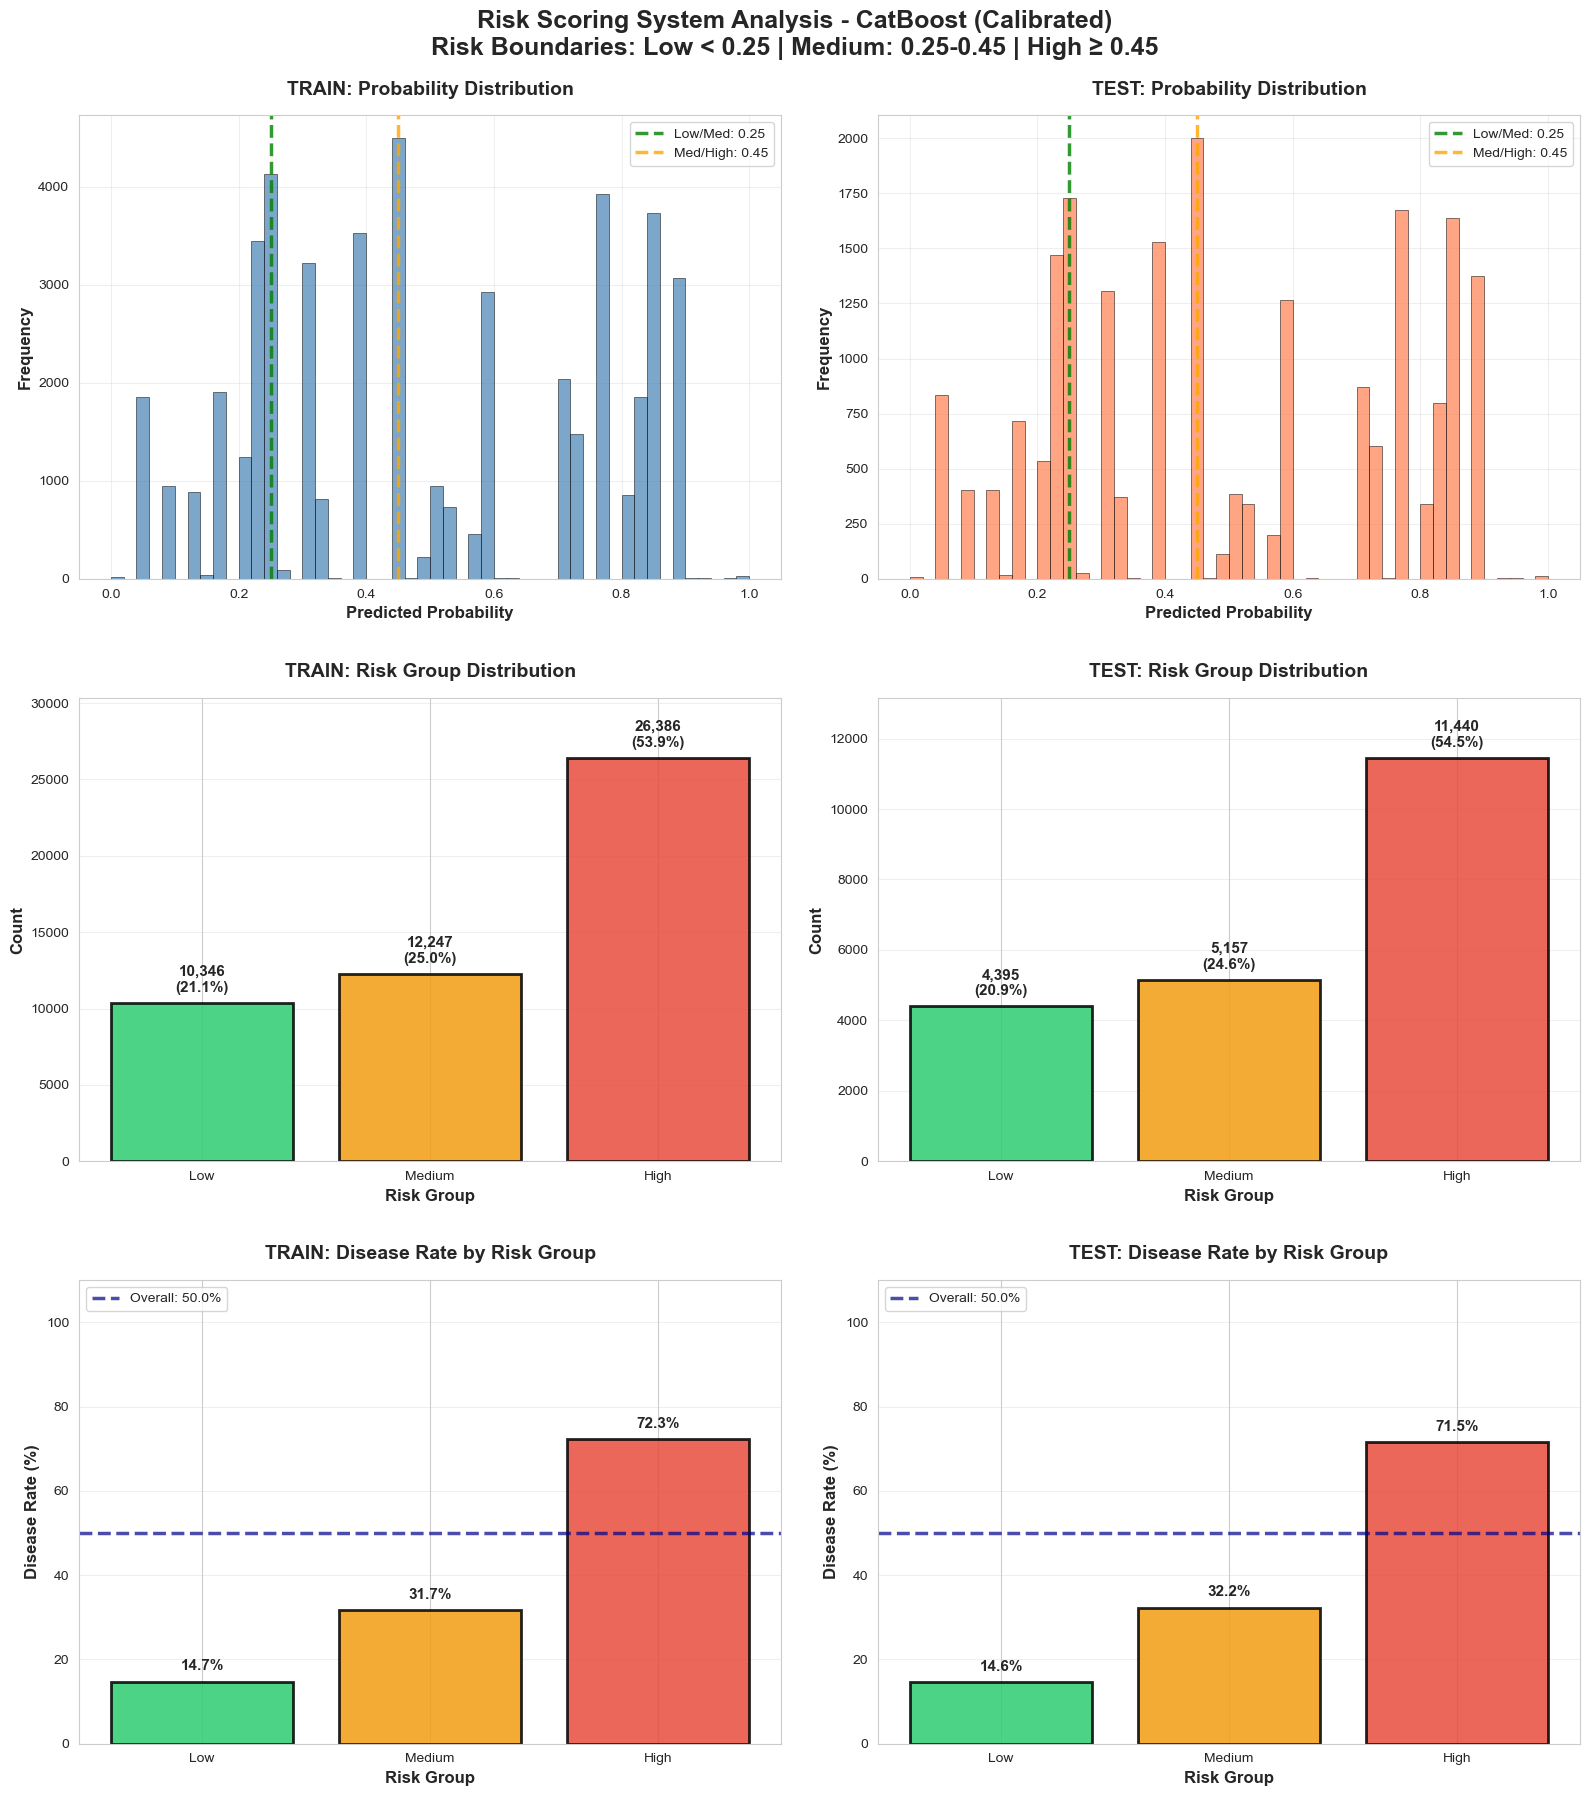

In [28]:
# ============================================================================
# RISK SCORING ANALYSIS - BEST CALIBRATED MODEL
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings

warnings.filterwarnings('ignore')

print("⚡ Risk Scoring Analysis - Best Calibrated Model\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

THRESHOLD_LOW_MEDIUM = 0.25
THRESHOLD_MEDIUM_HIGH = 0.45

RISK_ORDER = ['Low', 'Medium', 'High']
RISK_COLORS = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}

print(f"Risk Boundaries: Low < {THRESHOLD_LOW_MEDIUM} | Medium: {THRESHOLD_LOW_MEDIUM}-{THRESHOLD_MEDIUM_HIGH} | High ≥ {THRESHOLD_MEDIUM_HIGH}")

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'baseline model'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'figures'

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n[1/4] Loading data...")
X_train = pd.read_parquet(DATA_DIR / 'X_train.parquet')
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_train = pd.read_parquet(DATA_DIR / 'y_train.parquet').iloc[:, 0]
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0]
print(f"✓ Train: {X_train.shape}, Test: {X_test.shape}")

# ============================================================================
# LOAD MODEL
# ============================================================================

print("\n[2/4] Loading model...")
model_path = MODEL_DIR / 'best_model_calibrated.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract model and features
model = artifacts['calibrated_model']
features = artifacts.get('features', None)
model_type = artifacts.get('model_type', 'Unknown')

print(f"✓ Model Type: {model_type}")

# Ensure feature order matches
if features:
    X_train = X_train[features]
    X_test = X_test[features]
    print(f"✓ Features aligned: {len(features)}")

# ============================================================================
# GENERATE PREDICTIONS & RISK CATEGORIES
# ============================================================================

def categorize_risk(probs, low_thresh=THRESHOLD_LOW_MEDIUM, high_thresh=THRESHOLD_MEDIUM_HIGH):
    """Categorize probabilities into Low/Medium/High risk groups"""
    cats = np.empty(len(probs), dtype=object)
    cats[probs < low_thresh] = 'Low'
    cats[(probs >= low_thresh) & (probs < high_thresh)] = 'Medium'
    cats[probs >= high_thresh] = 'High'
    return cats

print("\n[3/4] Generating risk scores...")
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

train_risk = categorize_risk(y_train_prob)
test_risk = categorize_risk(y_test_prob)

print(f"✓ Train predictions: {len(y_train_prob)}")
print(f"✓ Test predictions: {len(y_test_prob)}")

# ============================================================================
# CREATE DATAFRAMES
# ============================================================================

scores = pd.DataFrame({
    'dataset': ['Train'] * len(y_train_prob) + ['Test'] * len(y_test_prob),
    'risk_score': np.concatenate([y_train_prob, y_test_prob]),
    'risk_group': np.concatenate([train_risk, test_risk]),
    'actual_disease': np.concatenate([y_train.values, y_test.values])
})

train_df = scores[scores['dataset'] == 'Train'].copy()
test_df = scores[scores['dataset'] == 'Test'].copy()

# ============================================================================
# COMPUTE STATISTICS
# ============================================================================

print("\n[4/4] Computing statistics...")
summary_stats = []

for dataset_name in ['Train', 'Test']:
    df = scores[scores['dataset'] == dataset_name]
    
    for risk_cat in RISK_ORDER:
        mask = df['risk_group'] == risk_cat
        
        if mask.sum() > 0:
            count = int(mask.sum())
            disease_count = int(df[mask]['actual_disease'].sum())
            disease_rate = float(df[mask]['actual_disease'].mean() * 100)
            avg_prob = float(df[mask]['risk_score'].mean())
            min_prob = float(df[mask]['risk_score'].min())
            max_prob = float(df[mask]['risk_score'].max())
            
            summary_stats.append({
                'Dataset': dataset_name,
                'Risk_Group': risk_cat,
                'Count': count,
                'Percentage': float(count / len(df) * 100),
                'Disease_Count': disease_count,
                'Disease_Rate': disease_rate,
                'Avg_Probability': avg_prob,
                'Min_Probability': min_prob,
                'Max_Probability': max_prob
            })

summary_df = pd.DataFrame(summary_stats)

# Print summary
print("\n" + "="*90)
print(f"RISK GROUP SUMMARY - {model_type} (Calibrated)")
print(f"Low Risk: < {THRESHOLD_LOW_MEDIUM} | Medium Risk: {THRESHOLD_LOW_MEDIUM}-{THRESHOLD_MEDIUM_HIGH} | High Risk: ≥ {THRESHOLD_MEDIUM_HIGH}")
print("="*90)
print(summary_df.to_string(index=False))
print("="*90)

# ============================================================================
# SAVE OUTPUTS
# ============================================================================

print("\nSaving outputs...")
scores.to_csv(METRICS_DIR / f'risk_scores_{model_type.lower()}_calibrated.csv', index=False)
summary_df.to_csv(METRICS_DIR / f'risk_summary_{model_type.lower()}_calibrated.csv', index=False)

print(f"✓ Scores: risk_scores_{model_type.lower()}_calibrated.csv")
print(f"✓ Summary: risk_summary_{model_type.lower()}_calibrated.csv")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nCreating visualizations...")
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle(f'Risk Scoring System Analysis - {model_type} (Calibrated)\nRisk Boundaries: Low < {THRESHOLD_LOW_MEDIUM} | Medium: {THRESHOLD_LOW_MEDIUM}-{THRESHOLD_MEDIUM_HIGH} | High ≥ {THRESHOLD_MEDIUM_HIGH}', 
             fontsize=18, fontweight='bold', y=0.995)

# ============================================================================
# ROW 1: Probability Distributions
# ============================================================================

for idx, (df, title, color) in enumerate([
    (train_df, 'TRAIN', 'steelblue'), 
    (test_df, 'TEST', 'coral')
]):
    ax = axes[0, idx]
    
    # Histogram
    ax.hist(df['risk_score'], bins=50, alpha=0.7, color=color, 
            edgecolor='black', linewidth=0.5)
    
    # Threshold lines
    ax.axvline(THRESHOLD_LOW_MEDIUM, color='green', linestyle='--', 
               linewidth=2.5, alpha=0.8, label=f'Low/Med: {THRESHOLD_LOW_MEDIUM}')
    ax.axvline(THRESHOLD_MEDIUM_HIGH, color='orange', linestyle='--', 
               linewidth=2.5, alpha=0.8, label=f'Med/High: {THRESHOLD_MEDIUM_HIGH}')
    
    ax.set_title(f'{title}: Probability Distribution', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3)

# ============================================================================
# ROW 2: Risk Group Distribution
# ============================================================================

for idx, (df, title) in enumerate([(train_df, 'TRAIN'), (test_df, 'TEST')]):
    ax = axes[1, idx]
    
    # Calculate counts
    counts = [df[df['risk_group'] == cat].shape[0] for cat in RISK_ORDER]
    
    # Bar chart
    bars = ax.bar(RISK_ORDER, counts, 
                  color=[RISK_COLORS[cat] for cat in RISK_ORDER],
                  edgecolor='black', linewidth=2, alpha=0.85)
    
    # Set y-axis limit
    max_count = max(counts)
    ax.set_ylim([0, max_count * 1.15])
    
    ax.set_title(f'{title}: Risk Group Distribution', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Risk Group', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    # Add labels
    for bar, count in zip(bars, counts):
        pct = count / len(df) * 100
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max_count * 0.02,
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

# ============================================================================
# ROW 3: Disease Rate by Risk Group
# ============================================================================

for idx, (df, title) in enumerate([(train_df, 'TRAIN'), (test_df, 'TEST')]):
    ax = axes[2, idx]
    
    # Calculate disease rates
    disease_rates = [df[df['risk_group'] == cat]['actual_disease'].mean() * 100 
                     for cat in RISK_ORDER]
    
    # Bar chart
    bars = ax.bar(RISK_ORDER, disease_rates, 
                  color=[RISK_COLORS[cat] for cat in RISK_ORDER],
                  edgecolor='black', linewidth=2, alpha=0.85)
    
    ax.set_title(f'{title}: Disease Rate by Risk Group', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Risk Group', fontsize=12, fontweight='bold')
    ax.set_ylabel('Disease Rate (%)', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 110])
    ax.grid(alpha=0.3, axis='y')
    
    # Add labels
    for bar, rate in zip(bars, disease_rates):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                f'{rate:.1f}%', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Overall baseline
    overall = df['actual_disease'].mean() * 100
    ax.axhline(overall, color='darkblue', linestyle='--', linewidth=2.5, alpha=0.7,
               label=f'Overall: {overall:.1f}%')
    ax.legend(fontsize=10, loc='upper left')

# ============================================================================
# SAVE FIGURE
# ============================================================================

plt.tight_layout(h_pad=3.0, w_pad=2.0)

output_path = FIGURES_DIR / f'02_risk_scoring_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {output_path.name}")
plt.show()
plt.close()

### Shap barplot

⚡ SHAP Feature Importance Analysis - Best Base Model

[1/5] Loading data...
✓ Test data: (20992, 14)

[2/5] Loading model...
✓ Model Type: CatBoost
✓ Model Name: Best Model (Base)
✓ Model Class: CatBoostClassifier
✓ Features aligned: 14

[3/5] Subsampling to 6000 samples...
✓ Sample size: (6000, 14)

[4/5] Computing SHAP values (this may take a few minutes)...
✓ Using TreeExplainer
✓ SHAP values computed: (6000, 14)

[5/5] Computing feature impacts...
✓ Top 20 features identified

Saving results...
✓ Saved: shap_feature_importance_catboost_base.csv

Creating visualization...
✓ Saved: 03_shap_bidirectional_importance.png


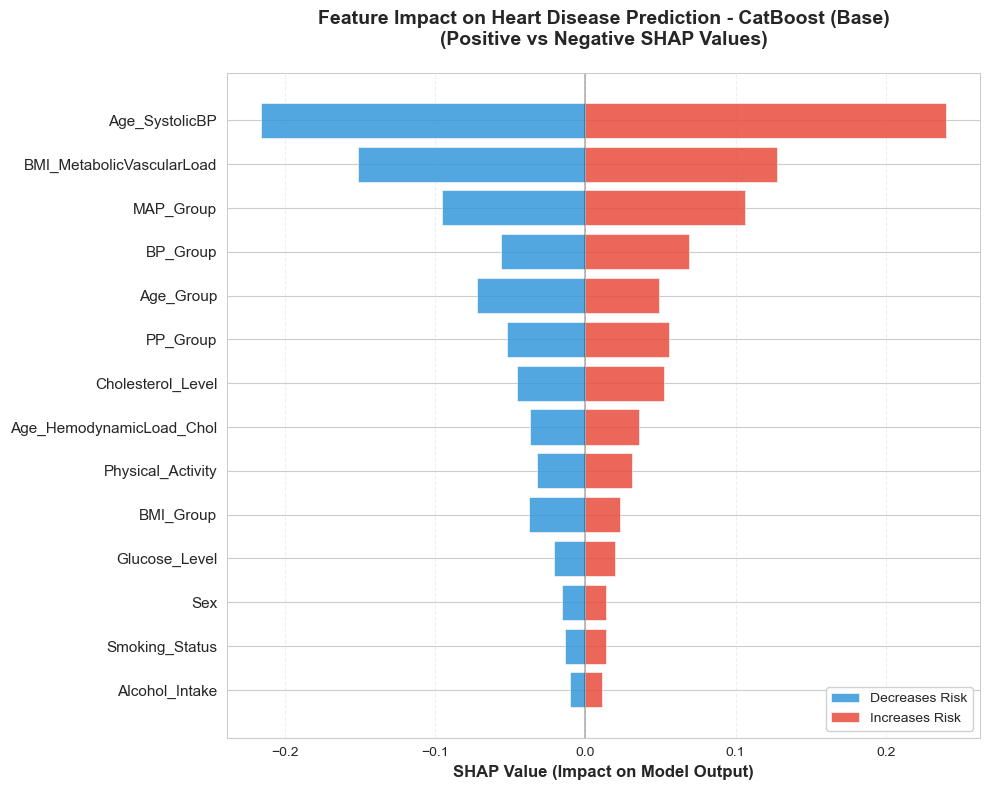

In [29]:
# ============================================================================
# SHAP FEATURE IMPORTANCE ANALYSIS - BEST BASE MODEL
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from pathlib import Path
import joblib
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

print("⚡ SHAP Feature Importance Analysis - Best Base Model\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

SAMPLE_SIZE = 6000
RANDOM_STATE = 42

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'baseline model'
FIGURES_DIR = REPORTS_DIR / 'figures'
METRICS_DIR = REPORTS_DIR / 'metrics'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print("[1/5] Loading data...")
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet').astype('float32')
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values
print(f"✓ Test data: {X_test.shape}")

# ============================================================================
# LOAD MODEL
# ============================================================================

print("\n[2/5] Loading model...")
model_path = MODEL_DIR / 'best_model_base.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract model and metadata
base_model = artifacts['model']
features = artifacts.get('features', None)
model_name = artifacts.get('model_name', 'Best Model (Base)')
model_type = artifacts.get('model_type', 'Unknown')

print(f"✓ Model Type: {model_type}")
print(f"✓ Model Name: {model_name}")
print(f"✓ Model Class: {type(base_model).__name__}")

# Ensure feature order matches
if features:
    X_test = X_test[features].astype('float32')
    print(f"✓ Features aligned: {len(features)}")

# ============================================================================
# SUBSAMPLE DATA
# ============================================================================

print(f"\n[3/5] Subsampling to {SAMPLE_SIZE} samples...")

if len(X_test) > SAMPLE_SIZE:
    _, X_sample, _, _ = train_test_split(
        X_test, y_test,
        test_size=SAMPLE_SIZE/len(X_test),
        stratify=y_test,
        random_state=RANDOM_STATE
    )
else:
    X_sample = X_test.copy()

print(f"✓ Sample size: {X_sample.shape}")

# ============================================================================
# COMPUTE SHAP VALUES
# ============================================================================

print("\n[4/5] Computing SHAP values (this may take a few minutes)...")

# Use TreeExplainer for tree-based models
try:
    explainer = shap.TreeExplainer(base_model)
    print("✓ Using TreeExplainer")
except Exception as e:
    print(f"⚠️  TreeExplainer failed: {e}")
    print("   Trying KernelExplainer...")
    try:
        explainer = shap.KernelExplainer(base_model.predict_proba, shap.sample(X_sample, 100))
        print("✓ Using KernelExplainer")
    except:
        explainer = shap.Explainer(base_model, X_sample)
        print("✓ Using default Explainer")

shap_values_obj = explainer(X_sample)

# Extract SHAP values for positive class (disease)
if hasattr(shap_values_obj, 'values'):
    shap_values = shap_values_obj.values
    # For binary classification, get positive class
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]
    elif len(shap_values.shape) == 2 and shap_values.shape[1] == 2:
        shap_values = shap_values[:, 1]
else:
    shap_values = shap_values_obj

print(f"✓ SHAP values computed: {shap_values.shape}")

feature_names = X_test.columns.tolist()

# ============================================================================
# COMPUTE FEATURE IMPACTS
# ============================================================================

print("\n[5/5] Computing feature impacts...")

shap_positive = np.where(shap_values > 0, shap_values, 0).mean(axis=0)
shap_negative = np.where(shap_values < 0, shap_values, 0).mean(axis=0)
shap_total = np.abs(shap_values).mean(axis=0)

shap_summary = pd.DataFrame({
    'feature': feature_names,
    'positive_impact': shap_positive,
    'negative_impact': shap_negative,
    'total_impact': shap_total
})

top_features = shap_summary.nlargest(20, 'total_impact').sort_values('total_impact')

print(f"✓ Top 20 features identified")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\nSaving results...")

summary_path = METRICS_DIR / f'shap_feature_importance_{model_type.lower()}_base.csv'
shap_summary.sort_values('total_impact', ascending=False).to_csv(summary_path, index=False)

print(f"✓ Saved: {summary_path.name}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nCreating visualization...")

fig, ax = plt.subplots(figsize=(10, 8))

y_positions = np.arange(len(top_features))

ax.barh(y_positions, top_features['negative_impact'], 
        color='#3498db', alpha=0.85, label='Decreases Risk',
        edgecolor='white', linewidth=0.5)

ax.barh(y_positions, top_features['positive_impact'], 
        color='#e74c3c', alpha=0.85, label='Increases Risk',
        edgecolor='white', linewidth=0.5)

ax.set_yticks(y_positions)
ax.set_yticklabels(top_features['feature'], fontsize=11)
ax.set_xlabel('SHAP Value (Impact on Model Output)', fontsize=12, fontweight='bold')
ax.set_title(f'Feature Impact on Heart Disease Prediction - {model_type} (Base)\n(Positive vs Negative SHAP Values)', 
             fontsize=14, fontweight='bold', pad=20)

ax.axvline(x=0, color='black', linewidth=1.2, alpha=0.3)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()

output_path = FIGURES_DIR / f'03_shap_bidirectional_importance.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')

print(f"✓ Saved: {output_path.name}")

plt.show()
plt.close()

### shap dot plot

⚡ SHAP Dot Plot Analysis - Best Base Model

[1/4] Loading data...
✓ Test data: (20992, 14)

[2/4] Loading model...
✓ Model Type: CatBoost
✓ Model Name: Best Model (Base)
✓ Model Class: CatBoostClassifier
✓ Features aligned: 14

[3/4] Subsampling to 6000 samples...
✓ Sample size: (6000, 14)

[4/4] Computing SHAP values (this may take a few minutes)...
✓ Using TreeExplainer
✓ SHAP values computed: (6000, 14)

Creating SHAP dot plot...
✓ Saved: 04_shap_dot_plot.png


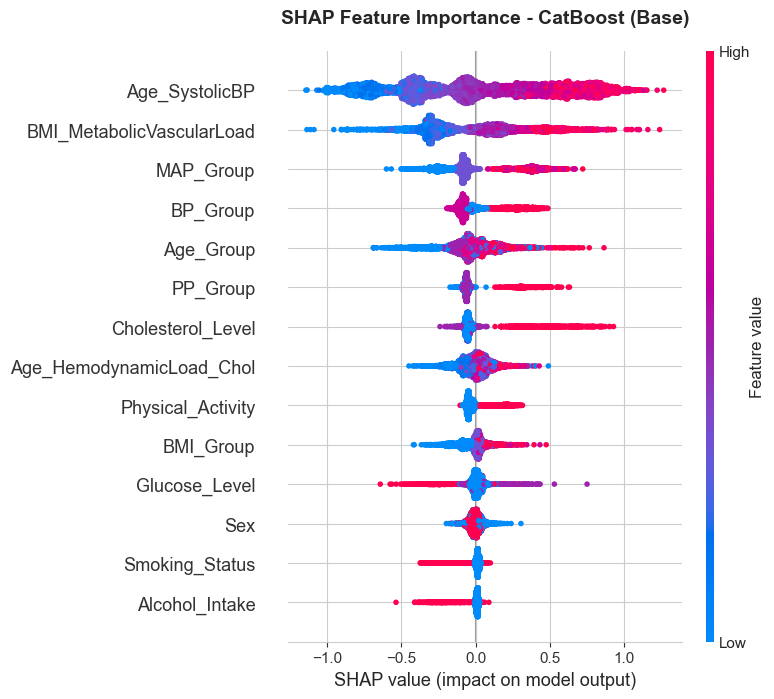


✅ SHAP DOT PLOT COMPLETE - CatBoost (Base)


In [30]:
# ============================================================================
# SHAP DOT PLOT ANALYSIS - BEST BASE MODEL
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from pathlib import Path
import joblib
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

print("⚡ SHAP Dot Plot Analysis - Best Base Model\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

SAMPLE_SIZE = 6000
RANDOM_STATE = 42

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'baseline model'
FIGURES_DIR = REPORTS_DIR / 'figures'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print("[1/4] Loading data...")
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0]
print(f"✓ Test data: {X_test.shape}")

# ============================================================================
# LOAD MODEL
# ============================================================================

print("\n[2/4] Loading model...")
model_path = MODEL_DIR / 'best_model_base.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract model and metadata
base_model = artifacts['model']
features = artifacts.get('features', None)
model_name = artifacts.get('model_name', 'Best Model (Base)')
model_type = artifacts.get('model_type', 'Unknown')

print(f"✓ Model Type: {model_type}")
print(f"✓ Model Name: {model_name}")
print(f"✓ Model Class: {type(base_model).__name__}")

# Ensure feature order matches
if features:
    X_test = X_test[features]
    print(f"✓ Features aligned: {len(features)}")

# ============================================================================
# SUBSAMPLE DATA
# ============================================================================

print(f"\n[3/4] Subsampling to {SAMPLE_SIZE} samples...")

if len(X_test) > SAMPLE_SIZE:
    _, X_sample, _, _ = train_test_split(
        X_test, y_test,
        test_size=SAMPLE_SIZE / len(X_test),
        stratify=y_test,
        random_state=RANDOM_STATE
    )
else:
    X_sample = X_test.copy()

print(f"✓ Sample size: {X_sample.shape}")

# ============================================================================
# COMPUTE SHAP VALUES
# ============================================================================

print("\n[4/4] Computing SHAP values (this may take a few minutes)...")

try:
    explainer = shap.TreeExplainer(base_model)
    print("✓ Using TreeExplainer")
except Exception as e:
    print(f"⚠️  TreeExplainer failed: {e}")
    print("   Trying alternative explainer...")
    try:
        explainer = shap.KernelExplainer(base_model.predict_proba, shap.sample(X_sample, 100))
        print("✓ Using KernelExplainer")
    except:
        explainer = shap.Explainer(base_model, X_sample)
        print("✓ Using default Explainer")

shap_values_obj = explainer(X_sample)

# Extract SHAP values for positive class
if hasattr(shap_values_obj, 'values'):
    shap_values = shap_values_obj.values
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]
    elif len(shap_values.shape) == 2 and shap_values.shape[1] == 2:
        shap_values = shap_values[:, 1]
else:
    shap_values = shap_values_obj

print(f"✓ SHAP values computed: {shap_values.shape}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nCreating SHAP dot plot...")

fig, ax = plt.subplots(figsize=(12, 10))

shap.summary_plot(
    shap_values,
    X_sample,
    plot_type='dot',
    max_display=20,
    show=False
)

plt.title(f'SHAP Feature Importance - {model_type} (Base)', 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

output_path = FIGURES_DIR / f'04_shap_dot_plot.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')

print(f"✓ Saved: {output_path.name}")

plt.show()
plt.close()

print(f"\n{'='*80}")
print(f"✅ SHAP DOT PLOT COMPLETE - {model_type} (Base)")
print(f"{'='*80}")

### SHAP Waterfall Plot: Individual Patient Risk Explanation

⚡ Individual Patient SHAP Analysis - Best Base Model

[1/5] Loading model...
✓ Model Type: CatBoost
✓ Model Name: Best Model (Base)
✓ Model Class: CatBoostClassifier

[2/5] Loading data...
✓ Features aligned: 14
✓ Test samples: 20992
✓ Risk scores loaded: 20992 test samples

[3/5] Selecting random patient...
✓ Patient index: 8661
✓ Actual outcome: Disease
✓ Risk group: High

[4/5] Computing SHAP values...
✓ Using TreeExplainer
✓ SHAP values computed

[5/5] Creating visualization...

✓ Saved: 05_individual_patient_shap_analysis.png
✓ Total features displayed: 14


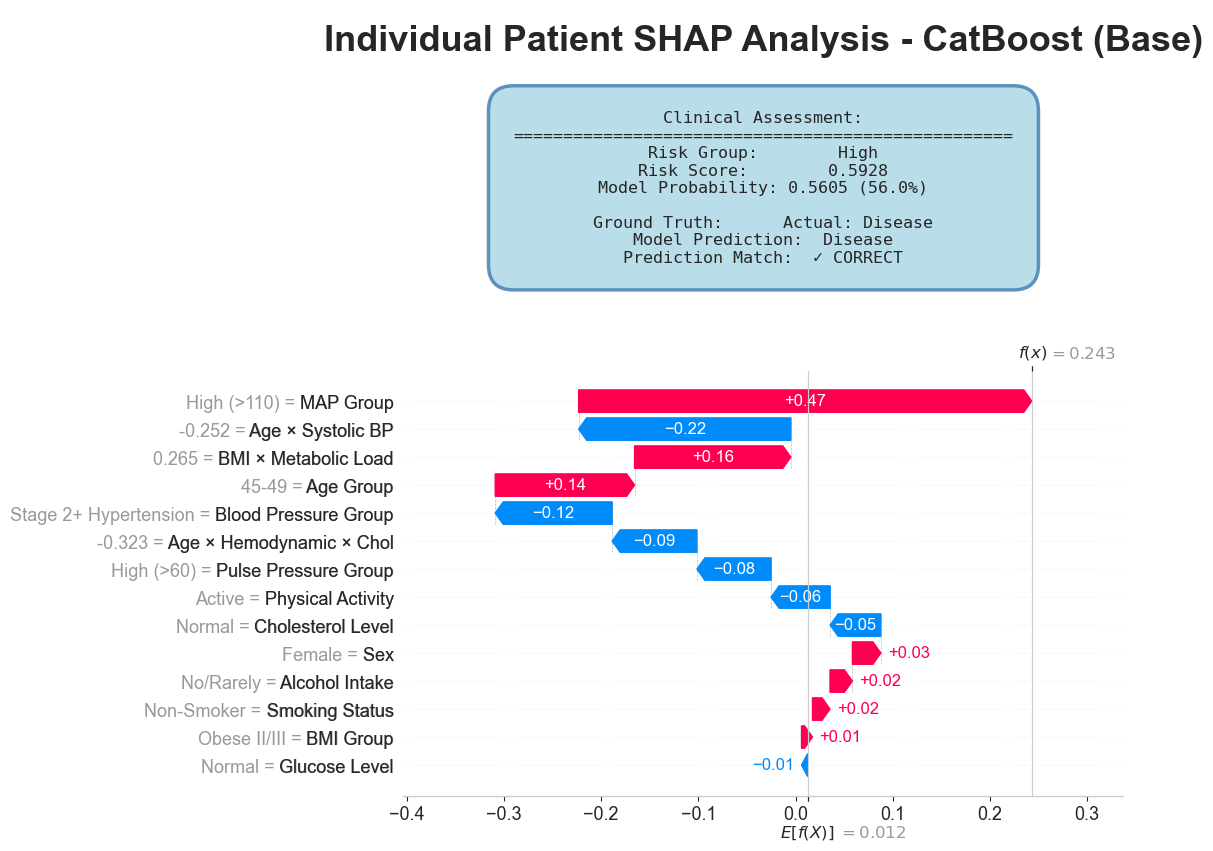

In [31]:
# ============================================================================
# INDIVIDUAL PATIENT SHAP ANALYSIS - BEST BASE MODEL
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from pathlib import Path
import joblib
import warnings
import time

warnings.filterwarnings('ignore')

print("⚡ Individual Patient SHAP Analysis - Best Base Model\n")

# ============================================================================
# CONFIGURATION - RAW FEATURES
# ============================================================================

# Feature names mapping (clean display names)
FEATURE_NAME_MAPPING = {
    'Sex': 'Sex',
    'Age_Group': 'Age Group',
    'BMI_Group': 'BMI Group',
    'BP_Group': 'Blood Pressure Group',
    'PP_Group': 'Pulse Pressure Group',
    'MAP_Group': 'MAP Group',
    'Systolic_BP': 'Systolic BP',
    'Diastolic_BP': 'Diastolic BP',
    'Cholesterol_Level': 'Cholesterol Level',
    'Glucose_Level': 'Glucose Level',
    'Smoking_Status': 'Smoking Status',
    'Alcohol_Intake': 'Alcohol Intake',
    'Physical_Activity': 'Physical Activity',
    'Age_Years': 'Age (Years)',
    'Pulse_Pressure': 'Pulse Pressure',
    'MAP': 'Mean Arterial Pressure',
    'BMI': 'BMI',
    'Age_SystolicBP': 'Age × Systolic BP',
    'BMI_MetabolicVascularLoad': 'BMI × Metabolic Load',
    'Age_HemodynamicLoad_Chol': 'Age × Hemodynamic × Chol'
}

# Categorical feature value mappings (value -> text label)
CATEGORICAL_MAPPINGS = {
    # Binary/Ordinal features (1-based)
    'Sex': {1: 'Female', 2: 'Male'},
    'Cholesterol_Level': {1: 'Normal', 2: 'Borderline High', 3: 'High'},
    'Glucose_Level': {1: 'Normal', 2: 'Prediabetes', 3: 'Diabetes'},
    'Smoking_Status': {1: 'Non-Smoker', 2: 'Smoker'},
    'Alcohol_Intake': {1: 'No/Rarely', 2: 'Yes/Regularly'},
    'Physical_Activity': {1: 'Active', 2: 'Inactive/Low'},
    
    # Binned/Grouped features (0-based indexing)
    'Age_Group': {0: '<40', 1: '40-44', 2: '45-49', 3: '50-54', 4: '55-59', 5: '60-64', 6: '65-69', 7: '70+'},
    'BMI_Group': {0: 'Normal/Underweight', 1: 'Overweight', 2: 'Obese I', 3: 'Obese II/III'},
    'BP_Group': {0: 'Normal', 1: 'Elevated', 2: 'Stage 1 Hypertension', 3: 'Stage 2+ Hypertension'},
    'PP_Group': {0: 'Low (<40)', 1: 'Normal (40-60)', 2: 'High (>60)'},
    'MAP_Group': {0: 'Low (<93)', 1: 'Normal (93-100)', 2: 'Elevated (100-110)', 3: 'High (>110)'}
}
# ============================================================================
# LAYOUT CONFIGURATION
# ============================================================================

# Figure dimensions
FIGURE_WIDTH = 40
FIGURE_HEIGHT = 50

# Element heights and gaps (as % of figure)
TITLE_HEIGHT_RATIO = 0.015
BOX_HEIGHT_RATIO = 0.03
GRAPH_HEIGHT_RATIO = 0.50
GAP_TITLE_TO_BOX = 0.15
GAP_BOX_TO_GRAPH = 0.20
MARGIN_TOP = 0.05
MARGIN_BOTTOM = 0.055

# Font sizes
TITLE_FONTSIZE = 26
BOX_FONTSIZE = 12

# Horizontal positioning
TITLE_X, TITLE_WIDTH = 0.05, 0.9
BOX_X, BOX_WIDTH = 0.15, 0.70
WATERFALL_X, WATERFALL_WIDTH = 0.05, 0.9

# Output settings
OUTPUT_DPI = 300
OUTPUT_PAD_INCHES = 0.3

# Auto-calculate Y positions
TITLE_Y = 1.0 - MARGIN_TOP - TITLE_HEIGHT_RATIO
BOX_Y = TITLE_Y - GAP_TITLE_TO_BOX - BOX_HEIGHT_RATIO
WATERFALL_Y = MARGIN_BOTTOM

# ============================================================================
# SETUP PATHS
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
DATA_DIR = ARTIFACTS_DIR / 'split data sets'
MODEL_DIR = ARTIFACTS_DIR / 'model'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'modeling' / 'baseline model'
METRICS_DIR = REPORTS_DIR / 'metrics'
FIGURES_DIR = REPORTS_DIR / 'figures'

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# LOAD MODEL
# ============================================================================

print("[1/5] Loading model...")
model_path = MODEL_DIR / 'best_model_base.pkl'

if not model_path.exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

artifacts = joblib.load(model_path)

# Extract model and metadata
base_model = artifacts['model']
features = artifacts.get('features', None)
model_name = artifacts.get('model_name', 'Best Model (Base)')
model_type = artifacts.get('model_type', 'Unknown')

print(f"✓ Model Type: {model_type}")
print(f"✓ Model Name: {model_name}")
print(f"✓ Model Class: {type(base_model).__name__}")

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n[2/5] Loading data...")
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').iloc[:, 0].values

# Remove target column if present
if 'target' in X_test.columns:
    X_test = X_test.drop('target', axis=1)

# Ensure feature order matches
if features:
    X_test = X_test[features]
    print(f"✓ Features aligned: {len(features)}")

print(f"✓ Test samples: {len(X_test)}")

# Load risk scores
risk_scores_path = METRICS_DIR / f'risk_scores_{model_type.lower()}_calibrated.csv'
if not risk_scores_path.exists():
    # Try alternative path
    risk_scores_path = METRICS_DIR / 'risk_scores.csv'
    if not risk_scores_path.exists():
        raise FileNotFoundError(f"Risk scores not found: {risk_scores_path}")

risk_scores = pd.read_csv(risk_scores_path)
# Filter for test set only
test_risk_scores = risk_scores[risk_scores['dataset'] == 'Test'].reset_index(drop=True)
print(f"✓ Risk scores loaded: {len(test_risk_scores)} test samples")

# ============================================================================
# SELECT RANDOM PATIENT
# ============================================================================

print("\n[3/5] Selecting random patient...")
random_seed = int(time.time() * 1000) % 2**32
np.random.seed(random_seed)
random_idx = np.random.randint(0, len(X_test))

sample_row = X_test.iloc[random_idx]
actual_outcome = y_test[random_idx]

# Get risk info for this patient
risk_score = test_risk_scores.iloc[random_idx]['risk_score']
risk_group = test_risk_scores.iloc[random_idx]['risk_group']

print(f"✓ Patient index: {random_idx}")
print(f"✓ Actual outcome: {'Disease' if actual_outcome == 1 else 'Healthy'}")
print(f"✓ Risk group: {risk_group}")

# ============================================================================
# COMPUTE SHAP VALUES
# ============================================================================

print("\n[4/5] Computing SHAP values...")
try:
    explainer = shap.TreeExplainer(base_model)
    print("✓ Using TreeExplainer")
except Exception as e:
    print(f"⚠️  TreeExplainer failed: {e}")
    explainer = shap.Explainer(base_model, X_test)
    print("✓ Using default Explainer")

shap_values_obj = explainer(X_test.iloc[[random_idx]])

if hasattr(shap_values_obj, 'values'):
    shap_values = shap_values_obj.values[0]
    if len(shap_values.shape) == 2:
        shap_values = shap_values[:, 1]
    base_value = shap_values_obj.base_values[0]
    if isinstance(base_value, np.ndarray):
        base_value = base_value[1] if len(base_value) > 1 else base_value[0]
else:
    shap_values = shap_values_obj[0]
    base_value = explainer.expected_value
    if isinstance(base_value, np.ndarray):
        base_value = base_value[1] if len(base_value) > 1 else base_value[0]

print("✓ SHAP values computed")

# ============================================================================
# DECODE FEATURE VALUES FOR DISPLAY (TEXT LABELS)
# ============================================================================

feature_list = X_test.columns.tolist()
decoded_data = []

for feat in feature_list:
    value = sample_row[feat]
    
    # Check if feature is categorical and has a mapping
    if feat in CATEGORICAL_MAPPINGS:
        # Convert to text label
        int_value = int(round(value))
        decoded_data.append(CATEGORICAL_MAPPINGS[feat].get(int_value, str(int_value)))
    else:
        # Continuous features: format with appropriate precision
        if abs(value) >= 100:
            decoded_data.append(f"{value:.1f}")
        elif abs(value) >= 10:
            decoded_data.append(f"{value:.2f}")
        else:
            decoded_data.append(f"{value:.3f}")

# Apply clean feature names
clean_names = [FEATURE_NAME_MAPPING.get(f, f) for f in feature_list]

# ============================================================================
# CREATE SHAP EXPLANATION
# ============================================================================

probability = 1 / (1 + np.exp(-(base_value + shap_values.sum())))
actual_label = 'Disease' if actual_outcome == 1 else 'Healthy'
predicted_label = 'Disease' if probability >= 0.5 else 'Healthy'
is_correct = (probability >= 0.5) == actual_outcome

shap_exp = shap.Explanation(
    values=shap_values,
    base_values=base_value,
    data=np.array(decoded_data),
    feature_names=clean_names
)

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n[5/5] Creating visualization...")

fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

# Title
ax_title = fig.add_axes([TITLE_X, TITLE_Y, TITLE_WIDTH, TITLE_HEIGHT_RATIO])
ax_title.axis('off')
ax_title.text(0.5, 0.5, f'Individual Patient SHAP Analysis - {model_type} (Base)',
              fontsize=TITLE_FONTSIZE, fontweight='bold', ha='center', va='center')

# Clinical Assessment Box
ax_box = fig.add_axes([BOX_X, BOX_Y, BOX_WIDTH, BOX_HEIGHT_RATIO])
ax_box.axis('off')

clinical_text = f"""Clinical Assessment:
{"="*50}
Risk Group:        {risk_group}
Risk Score:        {risk_score:.4f}
Model Probability: {probability:.4f} ({probability*100:.1f}%)

Ground Truth:      Actual: {actual_label}
Model Prediction:  {predicted_label}
Prediction Match:  {'✓ CORRECT' if is_correct else '✗ INCORRECT'}"""

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.85, 
             edgecolor='steelblue', linewidth=2.5, pad=1.5)
ax_box.text(0.5, 0.5, clinical_text, transform=ax_box.transAxes, 
            fontsize=BOX_FONTSIZE, ha='center', va='center', bbox=props, family='monospace')

# SHAP Waterfall Plot
ax_waterfall = fig.add_axes([WATERFALL_X, WATERFALL_Y, WATERFALL_WIDTH, GRAPH_HEIGHT_RATIO])
plt.sca(ax_waterfall)

total_features = len(shap_exp.values)
shap.plots.waterfall(shap_exp, max_display=total_features, show=False)

ax_waterfall.grid(False)
ax_waterfall.set_axisbelow(False)
plt.suptitle(' ', fontsize=1)

# ============================================================================
# SAVE FIGURE
# ============================================================================

output_path = FIGURES_DIR / f'05_individual_patient_shap_analysis.png'
plt.savefig(output_path, dpi=OUTPUT_DPI, bbox_inches='tight', pad_inches=OUTPUT_PAD_INCHES)

print(f"\n✓ Saved: {output_path.name}")
print(f"✓ Total features displayed: {total_features}")

plt.show()
plt.close()

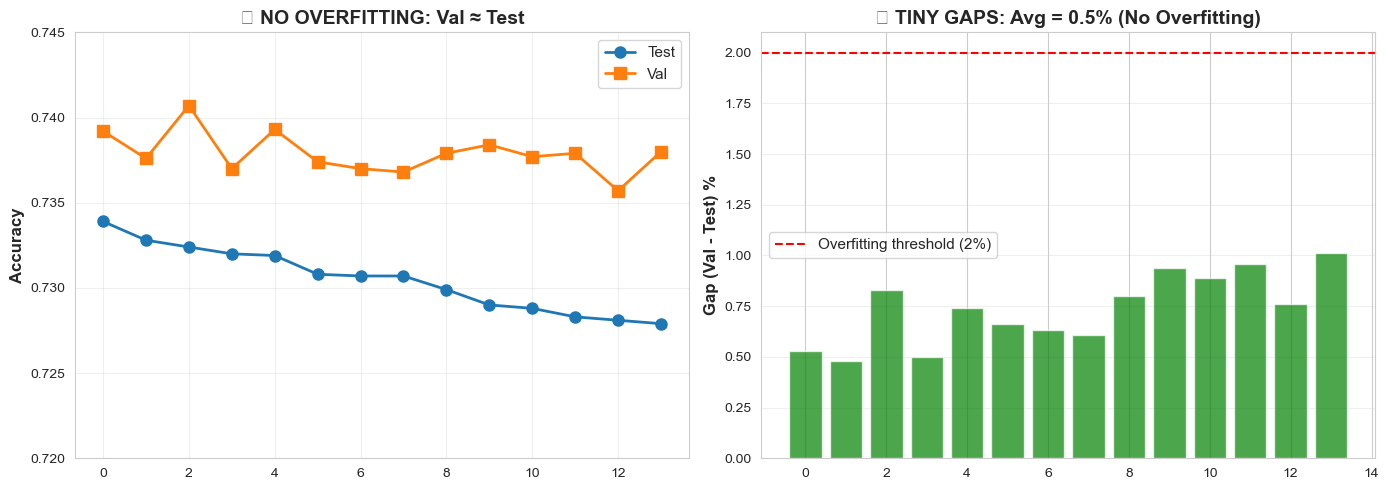

Average gap (Val - Test): 0.74%
Max gap: 1.01%
Status: ✅ NO OVERFITTING


In [10]:
import matplotlib.pyplot as plt

# Your data
features = ['Cholesterol', 'Alcohol', 'BMI_Group', 'Age_Group', 'BP_Group',
            'Physical', 'Glucose', 'Sex', 'Smoking', 'BMI_Metabolic',
            'PP_Group', 'MAP_Group', 'Age_Hemo', 'Age_Systolic']

test_acc = [0.7339, 0.7328, 0.7324, 0.7320, 0.7319, 0.7308, 0.7307, 0.7307, 
            0.7299, 0.7290, 0.7288, 0.7283, 0.7281, 0.7279]
val_acc = [0.7392, 0.7376, 0.7407, 0.7370, 0.7393, 0.7374, 0.7370, 0.7368, 
           0.7379, 0.7384, 0.7377, 0.7379, 0.7357, 0.7380]

# Create plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
axes[0].plot(range(len(features)), test_acc, 'o-', label='Test', linewidth=2, markersize=8)
axes[0].plot(range(len(features)), val_acc, 's-', label='Val', linewidth=2, markersize=8)
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('✅ NO OVERFITTING: Val ≈ Test', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.72, 0.745])

# Plot 2: Gap analysis
gaps = [abs(v - t) * 100 for v, t in zip(val_acc, test_acc)]
axes[1].bar(range(len(features)), gaps, color='green', alpha=0.7)
axes[1].set_ylabel('Gap (Val - Test) %', fontsize=12, fontweight='bold')
axes[1].set_title('✅ TINY GAPS: Avg = 0.5% (No Overfitting)', fontsize=14, fontweight='bold')
axes[1].axhline(y=2, color='red', linestyle='--', label='Overfitting threshold (2%)')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('overfitting_check.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Average gap (Val - Test): {sum(gaps)/len(gaps):.2f}%")
print(f"Max gap: {max(gaps):.2f}%")
print(f"Status: {'✅ NO OVERFITTING' if sum(gaps)/len(gaps) < 2 else '❌ OVERFITTING'}")
